In [1]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#librerias
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from PIL import Image
import torch
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models #just for debugging
from torchvision import transforms
from torchsummary import summary #just for debugging

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
#cleaning up
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes')

In [ ]:
#Just run once, and set the selected dir
os.mkdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes')

In [ ]:
#Just run once, and set the selected dir
!unzip "/content/drive/MyDrive/PROYECTO FINAL DL/classes.zip" -d "/content/drive/MyDrive/PROYECTO FINAL DL/classes"

In [3]:
#getting metadata from the CSV file (main purpose is get labels and its indexes)
data_skin = pd.read_csv('/content/drive/MyDrive/PROYECTO FINAL DL/DATASET_UNZIPPED/HAM10000_metadata.csv')

In [ ]:
#We leave aside other labels but these:
# nv - (melanocytic nevy)
# mel - (melanoma)
# bkl - (benign keratosis)
# labeled as 5, 4 & 2  

shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/bcc')
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/akiec')
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/df')
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/vasc')

In [5]:
len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel'))

1099

In [27]:
#we are gonna use 1099 images o the 3 most significant types, so we erase the others
import glob
removing_files = glob.glob('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel/*')
print(len(removing_files))

x=len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel'))
le=x
for i in removing_files:
    if (le == 1099):
      break
    else:
      os.remove(i) 
    le=le-1

removing_files = glob.glob('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/nv/*')

x=len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/nv'))
le=x
for i in removing_files:
    if (le == 1099):
      break
    else:
      os.remove(i) 
    le=le-1

1113


In [6]:
#we can confirm that theres only 1099 on each folder
print(len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/bkl')))
print(len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel')))
print(len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/nv')))

1099
1099
1099


In [129]:
#Loading dataset with imagefolder technique
train_dir='/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes' #getting image directory

TRANSFORM_IMG=transforms.Compose([
	transforms.Resize(size=(64,64)), #sizing all images to 64x64
	transforms.ToTensor()])

#making a dataset object for the imagefolder
skin_dataset = torchvision.datasets.ImageFolder(root=train_dir,transform=TRANSFORM_IMG) 

#splitting dataset into train and test
train = int(len(skin_dataset) * 0.8)
test = len(skin_dataset) - train

train_dataset, test_dataset = torch.utils.data.random_split(skin_dataset, [train, test])

train_dataLoader = DataLoader(train_dataset, shuffle=True, sampler=None, batch_size=16) #Getting data for training
test_dataLoader = DataLoader(test_dataset, shuffle=True, sampler=None, batch_size=16) #Getting data for testing


labels=np.array(skin_dataset.targets)
(unique,counts)=np.unique(labels,return_counts=True)
frecuencies_of_labels=np.asarray((unique, counts))

print(frecuencies_of_labels) #visualizing the amount of labels with its amount of images data
print(len(train_dataset))
print(len(test_dataset))

[[   0    1    2]
 [1099 1099 1099]]
2637
660


In [8]:
classes=train_dataLoader.dataset.dataset.classes
print(classes)
#dir(train_dataLoader.dataset.dataset.classes)

['bkl', 'mel', 'nv']


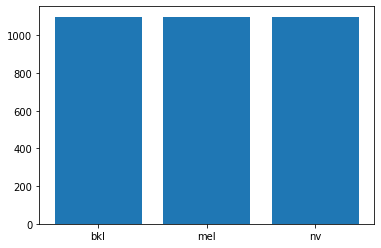

In [9]:
#frecuencies of datas against its labels
plt.bar(frecuencies_of_labels[0,:], frecuencies_of_labels[1,:])
plt.xticks(frecuencies_of_labels[0,:],classes);

In [10]:
data_skin['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

Feature batch shape: torch.Size([64, 64, 3, 16])
Labels batch shape: torch.Size([16])
torch.Size([3, 64, 64])


<ipython-input-11-5876fa045f23>:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  print(f"Feature batch shape: {train_features.T.size()}")


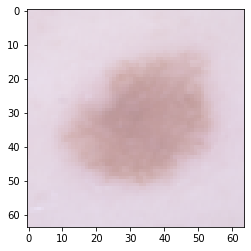

Label: nv
Feature batch shape: torch.Size([64, 64, 3, 16])
Labels batch shape: torch.Size([16])
torch.Size([3, 64, 64])


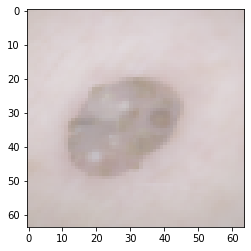

Label: bkl
Feature batch shape: torch.Size([64, 64, 3, 16])
Labels batch shape: torch.Size([16])
torch.Size([3, 64, 64])


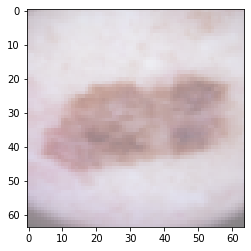

Label: mel
Feature batch shape: torch.Size([64, 64, 3, 16])
Labels batch shape: torch.Size([16])
torch.Size([3, 64, 64])


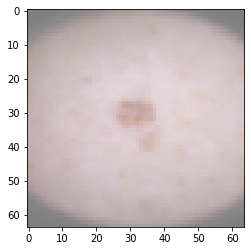

Label: nv


In [11]:
labels_map = {
    0: "bkl",
    1: "mel",
    2: "nv",
}

# Display image and label.
train_features, train_labels = next(iter(test_dataLoader))
for i in range(4):
  print(f"Feature batch shape: {train_features.T.size()}")
  print(f"Labels batch shape: {train_labels.size()}")
  img = train_features[i].squeeze()
  label = train_labels[i]
  print(img.shape)
  plt.imshow(img.T / 2 + 0.5)
  plt.show()
  print(f"Label: {labels_map[torch.IntTensor.item(label)]}")



In [12]:
print(train_features.shape)

torch.Size([16, 3, 64, 64])


In [111]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 13*13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [112]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [113]:
count=0
model_backup=[]
loss_list=[]
iteration_list=[]
accuracy_list=[]
for epoch in range(50):  # loop over the dataset multiple times
    net.train(True)
    running_loss = 0.0
    total=0
    correct=0
    for i, data in enumerate(train_dataLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs.to(device)
        labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
        running_loss += loss.item()
    count+=1
    # save statistics
    loss_list.append(running_loss)
    iteration_list.append(count)
    accuracy_list.append(correct / float(total))
    #save model
    PATH = 'skin_cancer_net_Epoch'+str(epoch)
    model_backup.append(torch.save(net.state_dict(), PATH))
    print(f'Epoch: [{epoch + 1}, {i}] Loss: {running_loss/len(train_dataLoader) }   Accuracy: {correct / float(total)}')


print('Finished Training')

#save model
PATH = 'skin_cancer_net'
torch.save(net.state_dict(), PATH)

#took 1h 12 min 20 s for train

Epoch: [1, 164] Loss: 1.0176879171169166   Accuracy: 0.4728858470916748
Epoch: [2, 164] Loss: 0.9399030475905448   Accuracy: 0.5589685440063477
Epoch: [3, 164] Loss: 0.8943381262548042   Accuracy: 0.5881683826446533
Epoch: [4, 164] Loss: 0.8280103166898092   Accuracy: 0.6207811832427979
Epoch: [5, 164] Loss: 0.7955826380036094   Accuracy: 0.6367083787918091
Epoch: [6, 164] Loss: 0.7321426102609345   Accuracy: 0.681835412979126
Epoch: [7, 164] Loss: 0.6904778536522027   Accuracy: 0.6992794871330261
Epoch: [8, 164] Loss: 0.622551623618964   Accuracy: 0.7360637187957764
Epoch: [9, 164] Loss: 0.5412020212773121   Accuracy: 0.7686765193939209
Epoch: [10, 164] Loss: 0.49022842864647054   Accuracy: 0.7997724413871765
Epoch: [11, 164] Loss: 0.40635272029674413   Accuracy: 0.8407281041145325
Epoch: [12, 164] Loss: 0.34176580955584845   Accuracy: 0.8684110641479492
Epoch: [13, 164] Loss: 0.25701877177890503   Accuracy: 0.9040576219558716
Epoch: [14, 164] Loss: 0.20847355723381042   Accuracy: 0.9

Real:       mel   bkl   mel   mel   mel   mel   nv    nv    bkl   mel   mel   mel   nv    bkl   nv    mel  
Predicted:  mel   mel   bkl   bkl   mel   bkl   nv    nv    bkl   nv    mel   mel   mel   bkl   nv    mel  


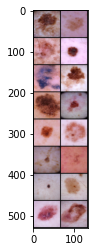

In [114]:
#predicted labels against real labels (16 samples)
dataiter = iter(test_dataLoader)
images, labels = next(dataiter)
# print images
plt.imshow(torchvision.utils.make_grid(images/ 2 + 0.5).T)
print('Real:      ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

#model
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels))))

In [115]:
#making an evaluation of the model
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval();
with torch.no_grad():
    for data in test_dataLoader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 65 %


In [116]:
#checking class prediction performance
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataLoader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: bkl   is 68.5 %
Accuracy for class: mel   is 61.3 %
Accuracy for class: nv    is 66.8 %


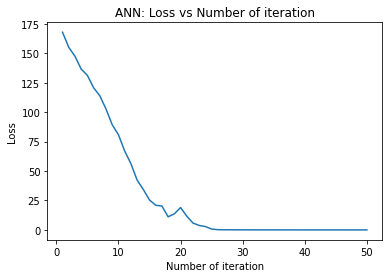

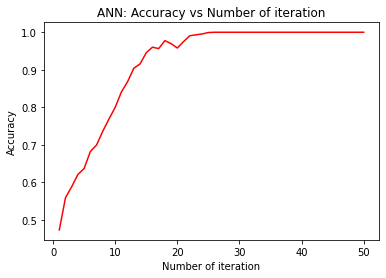

In [139]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [118]:
#figuring out the number of neurons of the first fully conected layer
#This is a pre-model
conv1=torch.nn.Conv2d(in_channels = 3, out_channels = 256, kernel_size = 3)

conv2=torch.nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3)

conv3=torch.nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3)

pool=nn.MaxPool2d(kernel_size=2, stride=2)



print(train_features.shape)
#visualizating an image
#plt.imshow(train_features[15,:,:,:].T)
#plt.show()


x=conv1(train_features)
print(x.shape)

x=pool(x)
print(x.shape)

x=conv2(x)
print(x.shape)

x=pool(x)
print(x.shape)

x=conv3(x)
print(x.shape)

x=pool(x)
print(x.shape)



#we can see that the correct number of neurons as the output channels x height x width

torch.Size([16, 3, 64, 64])
torch.Size([16, 256, 62, 62])
torch.Size([16, 256, 31, 31])
torch.Size([16, 128, 29, 29])
torch.Size([16, 128, 14, 14])
torch.Size([16, 64, 12, 12])
torch.Size([16, 64, 6, 6])


In [136]:
from torch.nn.modules.activation import Softmax
#Second model (bigger and with dropouts)
import torch.nn as nn
import torch.nn.functional as F


class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 3)
        self.conv2 = nn.Conv2d(256, 128, 3)
        self.conv3 = nn.Conv2d(128, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)        

        self.fc1 = nn.Linear(64*6*6, 32)
        self.fc2 = nn.Linear(32, 3)
 

        # Define proportion of neurons to dropout
        self.dropout = nn.Dropout(0.3)
        # Define softmax 
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = (self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


net2 = Net2()

In [137]:
#creating hyper parameters
learning_rate = 0.001
num_epochs = 100

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

In [138]:
count=0
model_backup2=[]
loss_list2=[]
iteration_list2=[]
accuracy_list2=[]
for epoch in range(100):  # loop over the dataset multiple times
    net2.train(True)
    running_loss = 0.0
    total=0
    correct=0
    for i, data in enumerate(train_dataLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs/255.0 #input normalization
        inputs.to(device)
        labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
        running_loss += loss.item()
    count+=1
    # save statistics
    loss_list2.append(running_loss)
    iteration_list2.append(count)
    accuracy_list2.append(correct / float(total))
    #save model
    PATH = 'skin_cancer_net2_Epoch'+str(epoch)
    model_backup.append(torch.save(net2.state_dict(), PATH))
    print(f'Epoch: [{epoch + 1}, {i}] Loss: {running_loss/len(train_dataLoader) }   Accuracy: {correct / float(total)}')


print('Finished Training')

#save model
PATH = 'skin_cancer_net2'
torch.save(net2.state_dict(), PATH)

#took

Epoch: [1, 164] Loss: 1.099431974960096   Accuracy: 0.32992035150527954
Epoch: [2, 164] Loss: 1.09888082706567   Accuracy: 0.33522942662239075
Epoch: [3, 164] Loss: 1.0987302353887847   Accuracy: 0.3344709873199463
Epoch: [4, 164] Loss: 1.0987536769924742   Accuracy: 0.31702691316604614
Epoch: [5, 164] Loss: 1.0986970164559104   Accuracy: 0.3344709873199463
Epoch: [6, 164] Loss: 1.0986875317313454   Accuracy: 0.3344709873199463
Epoch: [7, 164] Loss: 1.0987021720770633   Accuracy: 0.3329541087150574
Epoch: [8, 164] Loss: 1.0986886053374318   Accuracy: 0.3265073895454407
Epoch: [9, 164] Loss: 1.0986780274998058   Accuracy: 0.328403502702713
Epoch: [10, 164] Loss: 1.0987402872605758   Accuracy: 0.3310580253601074
Epoch: [11, 164] Loss: 1.098666455528953   Accuracy: 0.3344709873199463
Epoch: [12, 164] Loss: 1.098688717321916   Accuracy: 0.3329541087150574


KeyboardInterrupt: ignored

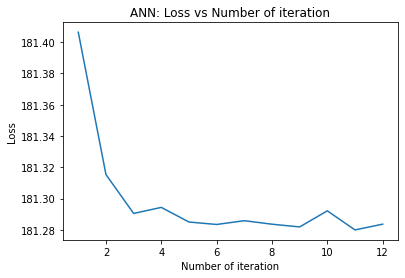

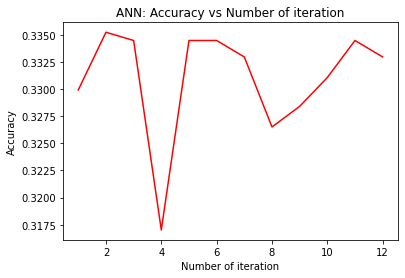

In [140]:
# visualization loss 
plt.plot(iteration_list2,loss_list2)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list2,accuracy_list2,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()